# Sentiment analysis in Pytorch 1: using a simple RNN

In [1]:
# all imports
import numpy as np
import pandas as pd
import torch
from torchtext import data
import torch.optim as optim
from plots.plots import plot_confusion_matrix, plot_histogram_from_labels
from text_processing.functions import simple_pre_process_text_df, simple_pre_process_text
from text_generation.sentiment import generate_sentiment_data
% matplotlib inline

Creating the data

In [2]:
generate_sentiment_data()

Speak about the dataset [First GOP debate twitter sentiment](https://www.kaggle.com/crowdflower/first-gop-debate-twitter-sentiment)

In [3]:
train_data_path = 'data/sentiment_train.csv'
test_data_path = 'data/sentiment_test.csv'

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

In [4]:
train_data.head()

,text,labels
0,Paula sempre foi curiosa,1
1,Adélia sempre foi desleal,0
2,"Mariana é atenta, mas as vezes ele parece ser ...",1
3,Djalmo não é transparente nem desobediente,2
4,Elisa é tanto cortês quanto estourada,2


In [5]:
test_data.head()

,text,labels
0,"Teodora é empenhada, mas as vezes ele parece s...",1
1,Adélia é tanto respeitador quanto mandãa,2
2,"Nídio parece ser tendencioso, mas eu não sei",2
3,"Cláudio parece ser trocista, mas eu não sei",2
4,Henoch é covarde,0


In [6]:
labels_legend = ['Negative','Positive', 'Neutral']
sentiment2int = {'Negative':0, 'Positive':1, 'Neutral':2}
int2sentiment = {i[1]: i[0] for i in sentiment2int.items()}
train_labels = train_data["labels"].values
test_labels =  test_data["labels"].values

Plotting the data histogram

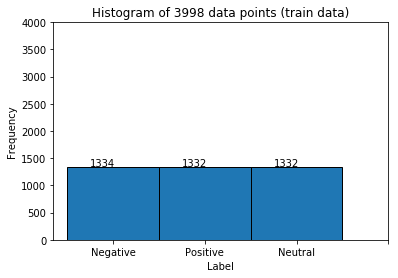

In [7]:
plot_histogram_from_labels(train_labels, labels_legend, "train data")

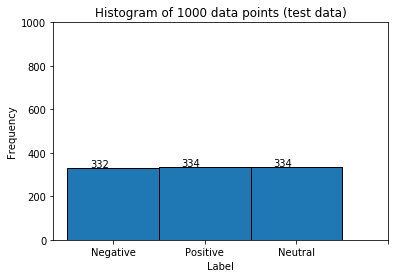

In [8]:
plot_histogram_from_labels(test_labels, labels_legend, "test data")

## Preprosseing and Vizualizating some tweets

In [9]:
print(train_data["text"].values[2])
print()
print(train_data["text"].values[3])
print()
print(train_data["text"].values[4])

Mariana é atenta, mas as vezes ele parece ser depressiva

Djalmo não é transparente nem desobediente

Elisa é tanto cortês quanto estourada


In [10]:
import re

def very_simple_pre_process_text(data, field="text"):
    data[field] = data[field].apply(lambda x: x.lower())
    data[field] = data[field].apply(lambda x: re.sub(r'[^\w\s]','',x))

def simple_pre_process_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r'[^\w\s]','',sentence)
    return sentence
    
very_simple_pre_process_text(train_data)
very_simple_pre_process_text(test_data)

In [11]:
print(train_data["text"].values[2])
print()
print(train_data["text"].values[3])
print()
print(train_data["text"].values[4])

mariana é atenta mas as vezes ele parece ser depressiva

djalmo não é transparente nem desobediente

elisa é tanto cortês quanto estourada


Now we can save the preprocessed text as a csv

In [12]:
train_data = train_data[["text", "labels"]]
test_data = test_data[["text", "labels"]]
train_data.to_csv('data/sentiment_train_clean.csv', header=False, index=False)
test_data.to_csv('data/sentiment_test_clean.csv', header=False, index=False)

We use the`data.Field` to hold all the text data:

> Field class models common text processing datatypes that can be represented
by tensors.  It holds a Vocab object that defines the set of possible values
for elements of the field and their corresponding numerical representations.
The Field object also holds other parameters relating to how a datatype
should be numericalized, such as a tokenization method and the kind of
Tensor that should be produced.

and the class `data.LabelField` to hold the labels:

> A label field is a shallow wrapper around a standard field designed to hold labels
for a classification task. Its only use is to set the unk_token and sequential to `None` by default.

In [13]:
TEXT = data.Field(tokenize='spacy')
LABEL = data.LabelField(tensor_type=torch.FloatTensor)

And so we can create a dataset by using the class `data.TabularDataset` and the data in the `csv` format

In [14]:
train = data.TabularDataset(path='data/sentiment_train_clean.csv',
                            format="csv",
                            fields=[('text', TEXT), ('label', LABEL)])

test = data.TabularDataset(path='data/sentiment_test_clean.csv',
                            format="csv",
                            fields=[('text', TEXT), ('label', LABEL)])

Creating the train-valid split (80$\%$ for training data and 20$\%$ for validation data)

In [15]:
train, valid = train.split(0.8)

In [16]:
print('len(train):', len(train))
print('len(valid):', len(valid))
print('len(test):', len(test))

len(train): 3198
len(valid): 800
len(test): 1000


Constructing the Vocabulary, using at maximun 25000 words

In [17]:
TEXT.build_vocab(train, max_size=25000)
LABEL.build_vocab(train)

In [18]:
print('len(TEXT.vocab):', len(TEXT.vocab))
print('len(LABEL.vocab):', len(LABEL.vocab))

len(TEXT.vocab): 1469
len(LABEL.vocab): 3


Printing the 20 most frequent words

In [19]:
print(TEXT.vocab.freqs.most_common(20))

[('é', 1872), ('foi', 816), ('vezes', 541), ('as', 541), ('sempre', 539), ('não', 536), ('parece', 531), ('ser', 531), ('mas', 531), ('era', 520), ('nunca', 277), ('nem', 274), ('mesmo', 272), ('que', 272), ('muito', 272), ('ele', 269), ('sei', 262), ('eu', 262), ('tanto', 257), ('quanto', 257)]


- `.itos` is the `int2str` method from the object `TEXT.vocab` 
- `.stoi` is the `str2int` method from the object `TEXT.vocab` 

In [20]:
print("TEXT.vocab.itos")
print("word", "index")

for i, word in enumerate(TEXT.vocab.itos[:10]):
    print(word, i)


print()
print("TEXT.vocab.stoi")
print("word", "index")
for word in "i love trump".split():
    print(word, TEXT.vocab.stoi[word])

TEXT.vocab.itos
word index
<unk> 0
<pad> 1
é 2
foi 3
as 4
vezes 5
sempre 6
não 7
mas 8
parece 9

TEXT.vocab.stoi
word index
i 0
love 0
trump 0


In [21]:
class RNNConfig(object):
    """
    Holds logistic regression model hyperparams.
    
    :param height: image height
    :type heights: int
    :param width: image width
    :type width: int
    :param channels: image channels
    :type channels: int
    :param batch_size: batch size for training
    :type batch_size: int
    :param epochs: number of epochs
    :type epochs: int
    :param save_step: when step % save_step == 0, the model
                      parameters are saved.
    :type save_step: int
    :param learning_rate: learning rate for the optimizer
    :type learning_rate: float
    :param momentum: momentum param
    :type momentum: float
    """
    def __init__(self,
                 vocab_size=25000,
                 batch_size=32,
                 embedding_dim=100,
                 rnn_dim=256,
                 output_dim=3,
                 epochs=3,
                 learning_rate=0.01,
                 momentum=0.1):
        self.vocab_size = vocab_size
        self.batch_size = batch_size
        self.embedding_dim = embedding_dim
        self.rnn_dim = rnn_dim
        self.output_dim = output_dim
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.momentum = momentum
        

    def __str__(self):
        """
        Get all attributs values.
        :return: all hyperparams as a string
        :rtype: str
        """
        status = "vocab_size = {}\n".format(self.vocab_size)
        status += "batch_size = {}\n".format(self.batch_size)
        status += "embedding_dim = {}\n".format(self.embedding_dim)
        status += "rnn_dim = {}\n".format(self.rnn_dim)
        status += "output_dim = {}\n".format(self.output_dim)
        status += "epochs = {}\n".format(self.epochs)
        status += "learning_rate = {}\n".format(self.learning_rate)
        status += "momentum = {}\n".format(self.momentum)
        return status

Hyperparams

In [22]:
config = RNNConfig(vocab_size=len(TEXT.vocab), output_dim=len(LABEL.vocab))
print(config)

vocab_size = 1469
batch_size = 32
embedding_dim = 100
rnn_dim = 256
output_dim = 3
epochs = 3
learning_rate = 0.01
momentum = 0.1



To define an iterator that batches examples of similar lengths together we use the class `data.BucketIterator`. 


In [23]:
# train_iter = data.BucketIterator(train, batch_size=config.batch_size, repeat=False)
# valid_iter = data.BucketIterator(valid, batch_size=config.batch_size, repeat=False)
# test_iter = data.BucketIterator(test, batch_size=len(test), repeat=False)

class DataHolder():
    """
    Class to store all data using the data.BucketIterator class.

    """
    def __init__(self,
                 config,
                 train,
                 valid,
                 test):        
        self.train_iter = data.BucketIterator(train, batch_size=config.batch_size, repeat=False)
        self.valid_iter = data.BucketIterator(valid, batch_size=config.batch_size, repeat=False)
        self.test_iter = data.BucketIterator(test, batch_size=len(test), repeat=False)
        
        
sent_data = DataHolder(config, train, valid, test) 


We can see some batch examples, here we should remember that the batch shape is `[sent len, batch size]`

In [24]:
i = np.random.randint(0, config.batch_size)
batch = next(iter(sent_data.train_iter))
print("batch.text.shape = {}".format(batch.text.shape))
print("batch.text.type = {}\n".format(batch.text.type()))

print("batch.label.shape = {}".format(batch.label.shape))
print("batch.label.type = {}\n".format(batch.label.type()))
batch_t = batch.text.transpose(0, 1)
example = batch_t[i]
for i in example:
    print(TEXT.vocab.itos[i], end=" ")

batch.text.shape = torch.Size([11, 32])
batch.text.type = torch.LongTensor

batch.label.shape = torch.Size([32])
batch.label.type = torch.FloatTensor

doralice nunca foi atenciosa <pad> <pad> <pad> <pad> <pad> <pad> <pad> 

Here we will define the RNN model using the `nn.module` class.

In [25]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.embedding = nn.Embedding(config.vocab_size, config.embedding_dim)
        self.rnn = nn.RNN(config.embedding_dim, config.rnn_dim)
        self.fc = nn.Linear(config.rnn_dim, config.output_dim)
        
    def forward(self, x):

        #x = [sent len, batch size]
        
        embedded = self.embedding(x)
        
        #embedded = [sent len, batch size, emb dim]
        
        output, hidden = self.rnn(embedded)
        
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        return self.fc(hidden.squeeze(0))

    def predict(self, x):
        out = self.forward(x)
        softmax = nn.Softmax(dim=1)
        out = softmax(out)
        indices = torch.argmax(out, 1)
        return indices

    def evaluate_bach(self, batch):
        prediction = model.predict(batch.text)
        labels = batch.label.type('torch.LongTensor')
        correct = torch.sum(torch.eq(prediction, labels)).float()
        accuracy = float(correct/labels.shape[0])
        return accuracy, prediction, labels
        


In [26]:
model = RNN(config)

Model's accuracy **before** the training

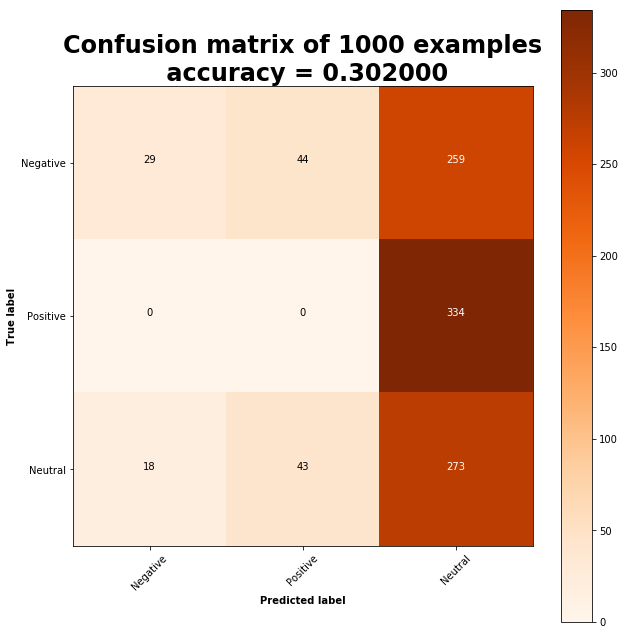

In [27]:
test_bach = next(iter(sent_data.test_iter))
_, pred, labels = model.evaluate_bach(test_bach)

plot_confusion_matrix(truth=labels.numpy(),
                      predictions=pred.numpy(),
                      save=False,
                      path="rnn_confusion_matrix.png",
                      classes=labels_legend)

Criando a função para treinar o modelo

In [28]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        logits = model(batch.text)
        label = batch.label.type("torch.LongTensor")
        loss = criterion(logits, label)
        acc, _, _ = model.evaluate_bach(batch)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc

    mean_loss = epoch_loss / len(iterator)
    mean_acc = epoch_acc / len(iterator)
        
    return mean_loss, mean_acc


def get_valid_loss(model, valid_iter, criterion):
    batch = next(iter(valid_iter))
    model.eval()
    logits = model(batch.text)
    label = batch.label.type("torch.LongTensor")
    loss = criterion(logits, label)
    return loss

def training_loop_text_classification(model, config, dataholder, model_path, verbose=True):
    """
    Train a model for text classification

    :param model: RNN classification model
    :type model: 
    :param config: image classification model
    :type config: LogisticRegression or DFN
    :param dataholder: data
    :type dataholder: DataHolder or DataHolderGentle
    :param model_path: path to save model params
    :type model_path: str
    :param verbose: param to control print
    :type verbose: bool
    """
    optimizer = optim.SGD(model.parameters(),
                          lr=config.learning_rate,
                          momentum=config.momentum)
    
    criterion = nn.CrossEntropyLoss()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = criterion.to(device)
    train_iter = dataholder.train_iter
    valid_iter = dataholder.valid_iter
    
    best_valid_loss = float("inf")
    
    for epoch in range(config.epochs):
        print("epoch = ({}/{})".format(epoch + 1, config.epochs))
        train_loss, train_acc = train(model, train_iter, optimizer, criterion)
        valid_loss = get_valid_loss(model,valid_iter, criterion)
        msg = "\ntrain_loss = {:.3f} | valid_loss = {:.3f}".format(float(train_loss),float(valid_loss))
        if float(valid_loss) < best_valid_loss:
            torch.save(model.state_dict(), model_path)
            best_valid_loss = float(valid_loss)
        if verbose:
            print(msg)
            print("train_acc = {}\n".format(train_acc))    

In [29]:
config = RNNConfig(vocab_size=len(TEXT.vocab),
                   output_dim=len(LABEL.vocab),
                   epochs=8,
                   learning_rate=0.03)
print(config)

model = RNN(config)

training_loop_text_classification(model, config, sent_data, "rnn.pkl")

vocab_size = 1469
batch_size = 32
embedding_dim = 100
rnn_dim = 256
output_dim = 3
epochs = 8
learning_rate = 0.03
momentum = 0.1

epoch = (1/8)

train_loss = 0.871 | valid_loss = 0.606
train_acc = 0.5452708333730698

epoch = (2/8)

train_loss = 0.422 | valid_loss = 0.375
train_acc = 0.7479374998807907

epoch = (3/8)

train_loss = 0.372 | valid_loss = 0.249
train_acc = 0.7639999997615814

epoch = (4/8)

train_loss = 0.367 | valid_loss = 0.395
train_acc = 0.7555000001192093

epoch = (5/8)

train_loss = 0.364 | valid_loss = 0.411
train_acc = 0.7444583332538605

epoch = (6/8)

train_loss = 0.364 | valid_loss = 0.419
train_acc = 0.742958333492279

epoch = (7/8)

train_loss = 0.469 | valid_loss = 0.301
train_acc = 0.7266458332538605

epoch = (8/8)

train_loss = 0.362 | valid_loss = 0.334
train_acc = 0.7560000002384186



Model's accuracy **after** the training

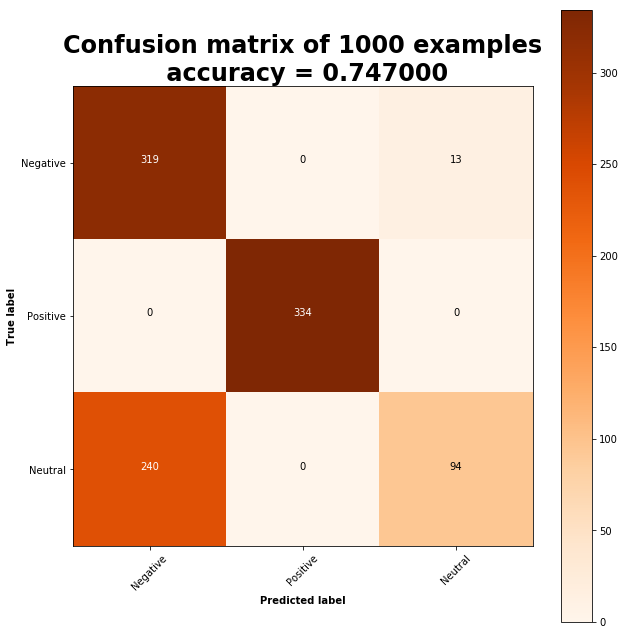

In [30]:
model = RNN(config)
model.load_state_dict(torch.load('rnn.pkl'))
_, pred, labels = model.evaluate_bach(test_bach)

plot_confusion_matrix(truth=labels.numpy(),
                      predictions=pred.numpy(),
                      save=False,
                      path="rnn_confusion_matrix.png",
                      classes=labels_legend)

Taking a look on some single examples

In [31]:
t1 = "Rurique era sensível"
t2 = "Nice sempre foi dissimulada"
t3 =  "Betina é tanto ponderada quanto indiferente"
t4 = "Mel parece ser quezilento, mas eu não sei	"
examples = [t1,t2, t3, t4]

In [32]:
for t in examples:
    print()
    print(t)
    text = simple_pre_process_text(t)
    text_as_int = [TEXT.vocab.stoi[word] for word in text.split(" ")]
    text_as_tensor = torch.Tensor(text_as_int).type('torch.LongTensor')
    text_as_tensor = text_as_tensor.view((1, text_as_tensor.shape[0]))
    text_as_tensor = text_as_tensor.t()  # putting in the format [sent len, batch size]
    pred = int(model.predict(text_as_tensor))
    print(int2sentiment[pred])


Rurique era sensível
Neutral

Nice sempre foi dissimulada
Positive

Betina é tanto ponderada quanto indiferente
Negative

Mel parece ser quezilento, mas eu não sei	
Positive
